In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

### Read in and clean the tweets, removing stopwords, RT's, and direct user mentions

%store -r all_tweets

stop_words = set(stopwords.words('english'))
def clean_tweet(tweet):
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet_tokens = [word for word in tweet_tokens if not word in stop_words and word != 'RT' and '@' not in word]
    return(tweet_tokens)

all_tweets['tokenized_tweet'] = all_tweets['tweet_text'].apply(lambda x: clean_tweet(x))
all_tweets['cleaned_tweets'] = all_tweets['tokenized_tweet'].apply(lambda x: ' '.join(x))

### Convert the collection of tweets to a TF-IDF matrix

vectorizer = TfidfVectorizer(stop_words='english', max_features = 2000, ngram_range = (1,1))
X = vectorizer.fit_transform(all_tweets['cleaned_tweets'])
X.shape


(447962, 2000)

In [147]:
from sklearn.decomposition import TruncatedSVD

## Perform the LSA 

svd_model = TruncatedSVD(n_components=25, algorithm='randomized', n_iter=100, random_state=1)
svd_model.fit(X)
terms = vectorizer.get_feature_names()

topic_dict = {}
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    #print("Topic "+str(i)+": ")
    #print(sorted_terms)
    topic_terms = []
    for k in sorted_terms:
        topic_terms.append(k[0])
    topic_dict[i] = topic_terms
    
X_topics = svd_model.fit_transform(X)

In [148]:
def set_top_topic(x):
    if(len(np.where(X_topics[x] == max(X_topics[x]))[0])):
        return(np.where(X_topics[x] == max(X_topics[x]))[0][0])
    else:
        return(np.where(X_topics[x] == max(X_topics[x]))[0])
    
def set_top_topic_score(x):
    if(len(np.where(X_topics[x] == max(X_topics[x]))[0])):
        return(round(max(X_topics[x]),4))
    else:
        return(round(max(X_topics[x]),4))

# Find the most relevent topic for each tweet
all_tweets['top_topic'] = [set_top_topic(i) for i in range(0,len(X_topics))]
all_tweets['top_topic_score'] = [set_top_topic_score(i) for i in range(0,len(X_topics))]
all_tweets['topic_desc'] = all_tweets['top_topic'].apply(lambda x: topic_dict[x])

# Add some additional metadata to the tweet
all_tweets['num_mentions'] = all_tweets['tweet_text'].str.count("@")
all_tweets['num_links'] = all_tweets['tweet_text'].str.count('http')
all_tweets['follower_ratio'] = all_tweets['num_followers'] / (all_tweets['num_following']+1)
all_tweets['num_hashtags'] = all_tweets['tweet_text'].str.count('#')

In [149]:
### Group tweets by user and keep users with > 10 tweets

grouped_users = all_tweets.groupby('user_id')
grouped_users_counts = grouped_users.size().sort_values()

frequent_users = list(grouped_users.size().sort_values().where(grouped_users_counts >= 10 ).dropna().index)
frequent_users_grouped = all_tweets[(all_tweets['user_id'].isin(frequent_users))].groupby('user_id')

unique_users = list(frequent_users_grouped.user_id.unique())

print(len(unique_users))

### Create a user data frame with summary data corresponding to each user

user_df = pd.DataFrame(unique_users, columns = ['user_id'])
user_df['avg_num_mentions'] = [round(frequent_users_grouped.get_group(i)["num_mentions"].mean(),3) for i in user_df['user_id']]
user_df['avg_num_links'] = [round(frequent_users_grouped.get_group(i)["num_links"].mean(),3) for i in user_df['user_id']]
user_df['follower_ratio'] = [round(frequent_users_grouped.get_group(i)["follower_ratio"].mean(),3) for i in user_df['user_id']]
user_df['avg_num_hashtags'] = [round(frequent_users_grouped.get_group(i)["num_hashtags"].mean(),3) for i in user_df['user_id']]
all_frequent_user_tweets = all_tweets[(all_tweets['user_id'].isin(frequent_users))].groupby('user_id')
user_df['retweet_unique_proportion'] = [round(all_frequent_user_tweets.get_group(i)['tweet_text'].str.count("^RT @").sum() / all_frequent_user_tweets.get_group(i).shape[0],3) for i in user_df['user_id']]
user_df['avg_similarity'] = [round(frequent_users_grouped.get_group(i)["top_topic_score"].mean(),3) for i in user_df['user_id']]


6151


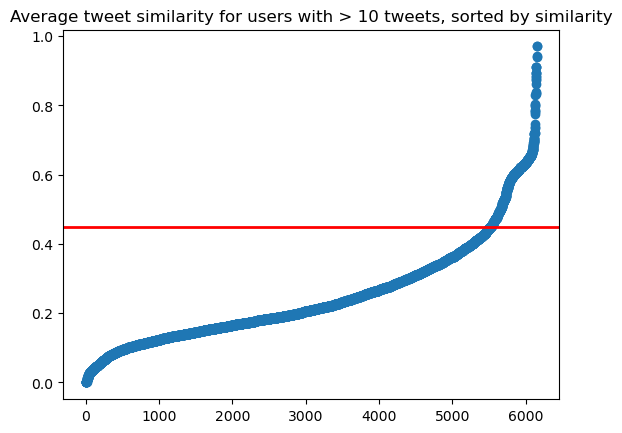

In [150]:
### Plot the sorted average similarity for all users

plt.title("Average tweet similarity for users with > 10 tweets, sorted by similarity")
plt.scatter(np.arange(0,len(user_df['avg_similarity'])),np.sort(user_df['avg_similarity']))
plt.axhline(linewidth=2, color='r', y=0.45)
plt.show()

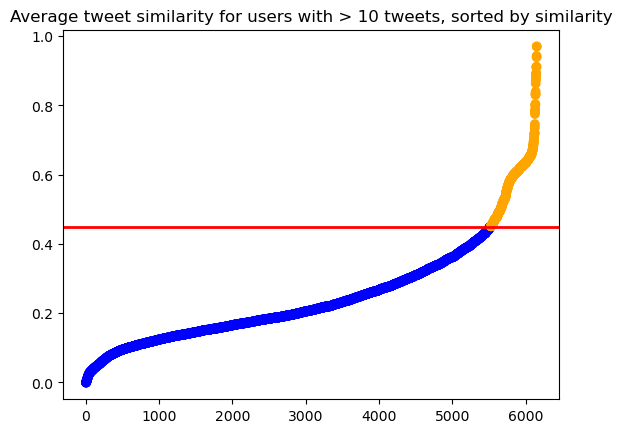

In [151]:
### Create a high content similarity around 45% average content similarity

def set_similarity(x):
    if x >= 0.45:
        return "High similarity"
    else:
        return "Low similarity"

user_df['similarity_label'] = user_df['avg_similarity'].apply(lambda x: set_similarity(x))

plt.title("Average tweet similarity for users with > 10 tweets, sorted by similarity")
plt.scatter(np.arange(0,len(user_df['avg_similarity'])),np.sort(user_df['avg_similarity']), 
            color = [('orange' if x > 0.45 else 'blue') for x in np.sort(user_df['avg_similarity'])])
plt.axhline(linewidth=2, color='r', y=0.45)
plt.show()


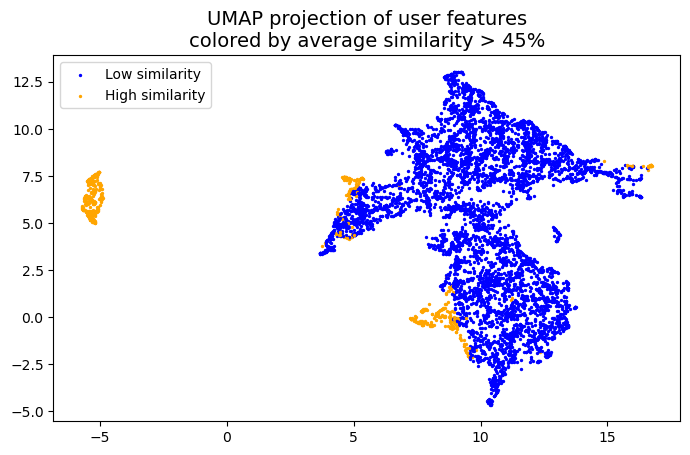

In [152]:
### Visualize spatial relations of content similarity via UMAP

import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(random_state=42)

user_data = user_df.loc[:, user_df.columns != 'similarity_label' ]
user_data = user_data.loc[:, user_data.columns != 'user_id' ].values
user_data = StandardScaler().fit_transform(user_data)
embedding = reducer.fit_transform(user_data)

color_map = {"High similarity":'orange', "Low similarity":'blue'}
labelled = {"High similarity":0, "Low similarity":0}


fig = plt.figure(figsize = (7,4.2))
for i in range(0,len(embedding)):
    if not labelled[user_df.at[user_df.index[i],"similarity_label"]]:
        labelled[user_df.at[user_df.index[i],"similarity_label"]] = 1
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[user_df.at[user_df.index[i],"similarity_label"]], 
                label = user_df.at[user_df.index[i],"similarity_label"], s=2)
    else:
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[user_df.at[user_df.index[i],"similarity_label"]], s=2)

plt.legend(loc='upper left')
plt.tight_layout()
plt.title('UMAP projection of user features\ncolored by average similarity > 45%', fontsize=14)
plt.rcParams.update(plt.rcParamsDefault)


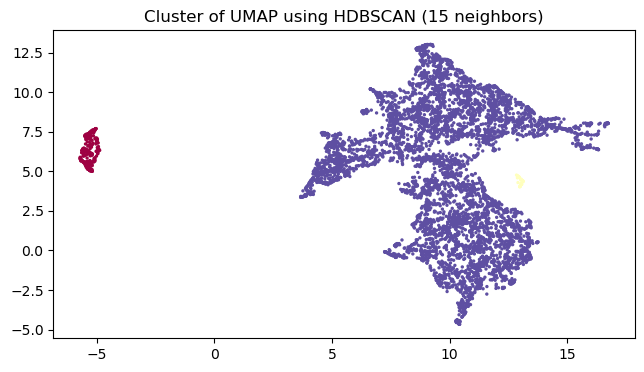

In [153]:
import hdbscan

### Subsetting the out-group using HDBSCAN

labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=15
).fit_predict(embedding)

fig = plt.figure(figsize = (7.5,4))
plt.title("Cluster of UMAP using HDBSCAN (15 neighbors)")
clustered = (labels_hdbscan >= 0)
plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdbscan[clustered], s=2, cmap='Spectral')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]

<ipython-input-154-42c6f9efc13c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df_outgroup["top_topic"] = [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in user_df_outgroup['user_id']]


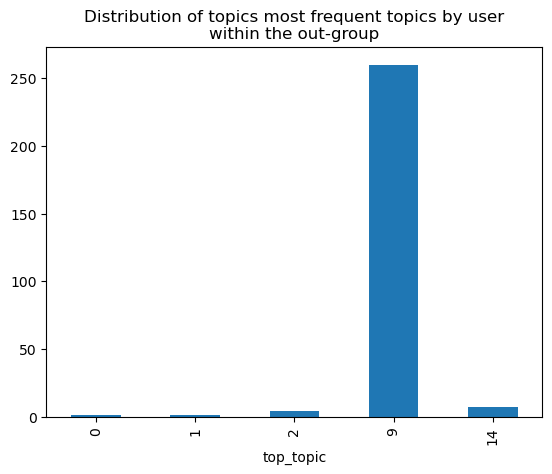

In [154]:
### Identifying topics of discussion within the outgroup

user_df_outgroup = user_df[user_df["cluster_hdbscan"] == 0] 
user_df_outgroup["top_topic"] = [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in user_df_outgroup['user_id']]

plt.title("Distribution of topics most frequent topics by user\nwithin the out-group")
user_df_outgroup.groupby(["top_topic"]).size().plot.bar()
plt.show()

#topic_dict[9]

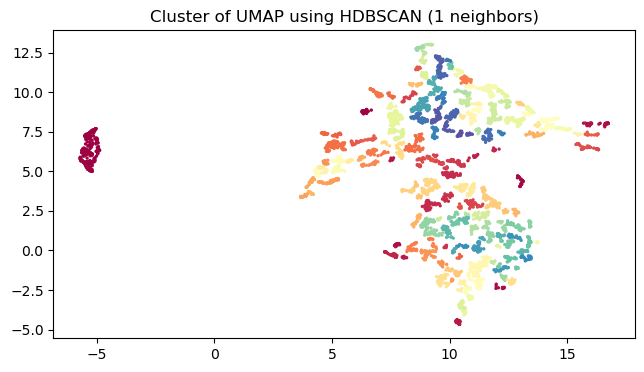

In [155]:
### Reclustering to break up the central group

labels_hdbscan = hdbscan.HDBSCAN().fit_predict(embedding)

fig = plt.figure(figsize = (7.5,4))
plt.title("Cluster of UMAP using HDBSCAN (1 neighbors)")
clustered = (labels_hdbscan >= 0)
plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdbscan[clustered], s=2, cmap='Spectral')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]

In [156]:
### Determine clusters with higher average similarity

import numpy

cluster_list = list(user_df.cluster_hdbscan.unique())
cluster_list_sorted = sorted(cluster_list)
cluster_df = pd.DataFrame(cluster_list_sorted[1:], columns = ['cluster'])

def getTopTopics(cluster):
    cluster_users = user_df[user_df["cluster_hdbscan"] == cluster] 
    return [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in cluster_users['user_id']]

def getNumTweets(cluster):
    cluster_users = user_df[user_df["cluster_hdbscan"] == cluster]
    return [frequent_users_grouped.get_group(i).shape[0] for i in cluster_users['user_id']]

#def getAverageTweetSimilarity(cluster):
#    cluster_users = user_df[user_df["cluster_hdbscan"] == cluster]
#    user_tweets = [frequent_users_grouped.get_group(i)["top_topic_score"] for i in cluster_users['user_id']]
#    print(len(user_tweets))
    #return 

cluster_grouped_users = user_df.groupby('cluster_hdbscan')
cluster_df['num_users'] = [cluster_grouped_users.get_group(i).shape[0] for i in cluster_df['cluster']]
cluster_df['total_num_tweets'] = [sum(getNumTweets(i)) for i in cluster_df['cluster']]
cluster_df['avg_similarity_user'] = [round(cluster_grouped_users.get_group(i)["avg_similarity"].mean(),3) for i in cluster_df['cluster']]
#cluster_df['avg_similarity_tweet'] = [getAverageTweetSimilarity(i) for i in cluster_df['cluster']]
cluster_df["top_topic_by_user"] = [getTopTopics(i) for i in cluster_df['cluster']]

cluster_df.head()

,cluster,num_users,total_num_tweets,avg_similarity_user,top_topic_by_user
0,0.0,273,5864,0.625,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 14, 9, 9, 9, 9,..."
1,1.0,33,516,0.358,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
2,2.0,9,329,0.158,"[7, 0, 2, 2, 1, 19, 19, 0, 19]"
3,3.0,13,315,0.184,"[5, 2, 2, 0, 12, 19, 19, 19, 2, 19, 0, 16, 19]"
4,4.0,8,184,0.155,"[19, 19, 7, 19, 2, 19, 7, 7]"


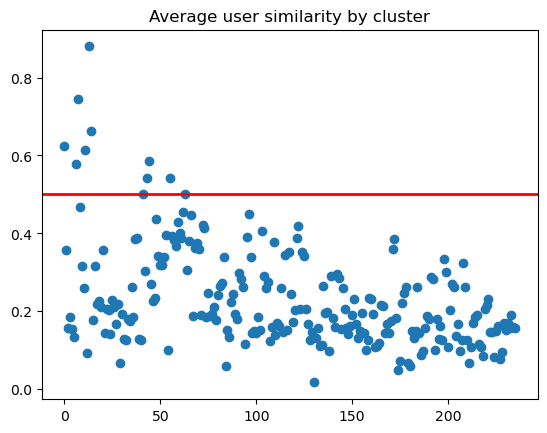

In [157]:
plt.title("Average user similarity by cluster")
plt.scatter(np.arange(0,len(cluster_df['avg_similarity_user'])),cluster_df['avg_similarity_user'])
plt.axhline(linewidth=2, color='r', y=0.5)
plt.show()

In [158]:
### Subset out the high similarity clusters with over 10 users

high_similarity_clusters = cluster_df[cluster_df['avg_similarity_user'] >= 0.5] 
high_similarity_clusters

,cluster,num_users,total_num_tweets,avg_similarity_user,top_topic_by_user
0,0.0,273,5864,0.625,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 14, 9, 9, 9, 9,..."
6,6.0,26,650,0.578,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1..."
7,7.0,14,218,0.746,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]"
11,11.0,13,337,0.613,"[1, 17, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 1]"
13,13.0,13,363,0.880,"[1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1]"
14,14.0,26,934,0.662,"[1, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 2, 0, ..."
41,41.0,18,332,0.501,"[2, 14, 14, 4, 14, 14, 4, 4, 4, 14, 14, 4, 14,..."
43,43.0,5,52,0.543,"[0, 0, 4, 4, 4]"
44,44.0,24,721,0.585,"[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
55,55.0,33,1011,0.543,"[0, 14, 7, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,..."


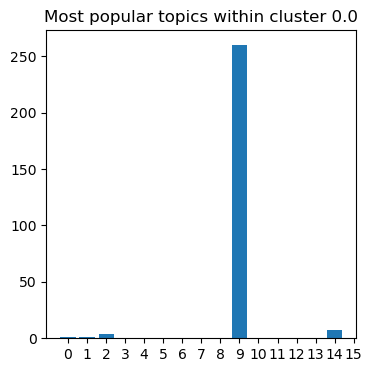

Top topic: 9


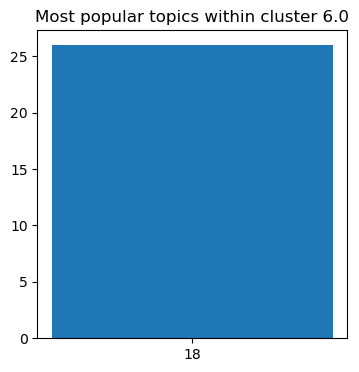

Top topic: 18


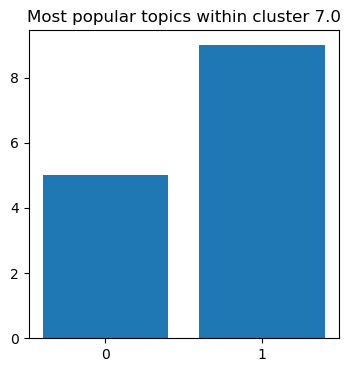

Top topic: 1


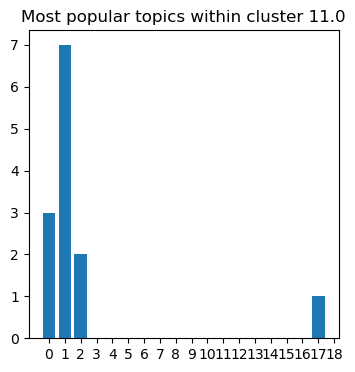

Top topic: 1


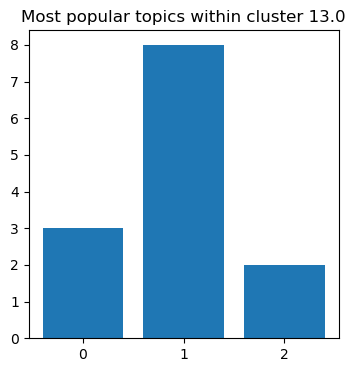

Top topic: 1


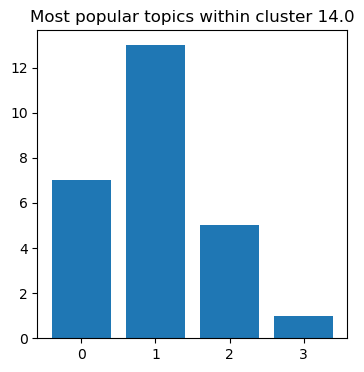

Top topic: 1


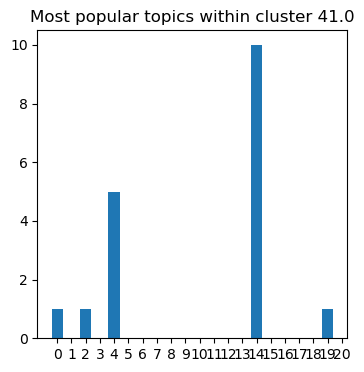

Top topic: 14


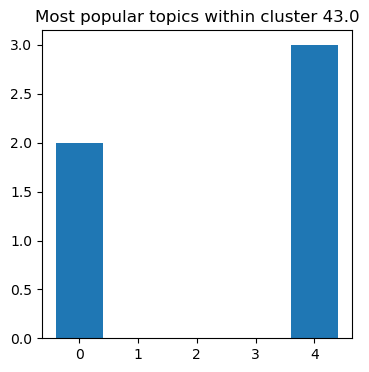

Top topic: 4


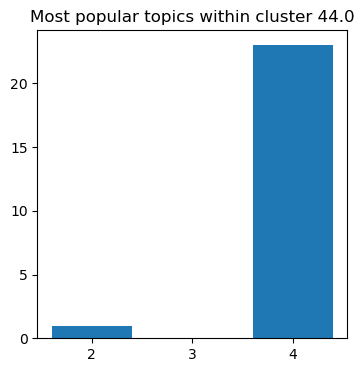

Top topic: 4


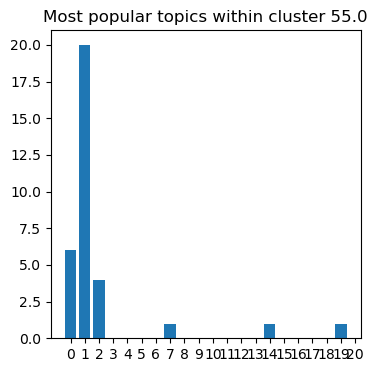

Top topic: 1


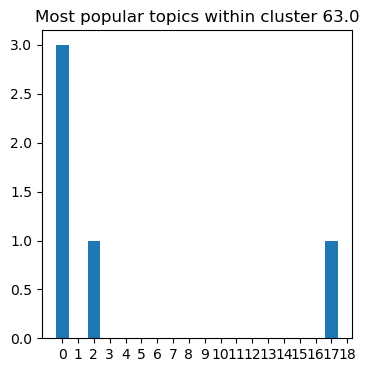

Top topic: 0


In [159]:
for i in high_similarity_clusters["cluster"]:
    keys, counts = np.unique(high_similarity_clusters.loc[high_similarity_clusters["cluster"] == i,"top_topic_by_user"][i],
                         return_counts=True)
    fig, ax = plt.subplots(figsize = (4,4))
    plt.title("Most popular topics within cluster %s"%(i))
    plt.xticks([x for x in range(0,24)])
    plt.bar(keys,counts)
    plt.show()
    print("Top topic: %s"%(keys[numpy.where(counts == max(counts))][0]))
    #print(topic_dict[keys[numpy.where(counts == max(counts))][0]])

